In [60]:
import numpy as np
import sklearn as skl
from sklearn.preprocessing import OneHotEncoder
import scipy.io as scio
import scipy
import skimage as sk
import skimage.io as skio
from skimage import color
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import h5py
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers.core import Flatten, Reshape, Dropout
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import SGD, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.layers import Input
from PIL import Image
import math
from tensorflow.python.client import device_lib
%matplotlib inline

print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10668417081780336618
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 228458496
locality {
  bus_id: 1
}
incarnation: 15302034817075775895
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0"
]


## Load Datasets

In [74]:
(mnist_X_train, mnist_y_train), (mnist_X_test, mnist_y_test) = mnist.load_data()
svhn_train = scio.loadmat('svhn_train.mat')
svhn_test = scio.loadmat('svhn_test.mat')
svhn_X_train = svhn_train['X']
svhn_y_train = svhn_train['y']
svhn_X_test = svhn_test['X']
svhn_y_test = svhn_test['y']
svhn_X_train = np.array([svhn_X_train[:, :, :, i] for i in range(svhn_X_train.shape[-1])])
svhn_X_test = np.array([svhn_X_test[:, :, :, i] for i in range(svhn_X_test.shape[-1])])

## DCGAN

In [87]:
def generator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3), padding='same'))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    return model

def discriminator():
    model = Sequential()
    model.add(
            Conv2D(64, (5, 5),
            padding='same',
            input_shape=(28, 28, 1))
            )
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model
#     model = Sequential()
#     model.add(Conv2D(64, (3, 3), padding='same', input_shape=(28, 28, 1), kernel_initializer='glorot_normal'))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='glorot_normal'))
#     model.add(Activation('relu'))
#     model.add(Conv2D(1, (4, 4), padding='same', kernel_initializer='glorot_normal'))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dense(1))
#     model.add(Activation('sigmoid'))
#     return model

def generator_with_discriminator(g, d):
    model = Sequential()
    model.add(g)
    d.trainable = False
    model.add(d)
    return model

## Training

In [88]:
def train(mnist_X_train, svhn_X_train, g=None, d=None, batch_size=128, epochs=100):
    mnist_X_train = (mnist_X_train.astype(np.float32) - 127.5)/127.5
    svhn_X_train = (svhn_X_train.astype(np.float32) - 127.5)/127.5
    if not g: g = generator()
    if not d: d = discriminator()
    g_d = generator_with_discriminator(g, d)
    g_d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_d.compile(loss='binary_crossentropy', optimizer=g_d_optim)
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    d.trainable = True
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    for e in range(epochs):
        print('Epoch: {}'.format(e))
        for i in range(int(mnist_X_train.shape[0] / batch_size)):
            # Create batches
#             batch_rand_X = np.random.uniform(-1, 1, size=(batch_size, 32, 32, 3))
            batch_mnist_X = mnist_X_train[np.random.randint(mnist_X_train.shape[0], size=batch_size)]
            batch_svhn_X = svhn_X_train[np.random.randint(svhn_X_train.shape[0], size=batch_size)]
            
        
            # Generate MNIST examples from noise for training
            g_train_data = g.predict(batch_svhn_X, verbose=0)
            
            # Label as real or fake
            y_real, y_fake = np.ones(batch_size), np.zeros(batch_size)
            X_train, y_train = np.vstack((batch_mnist_X, g_train_data)), np.hstack((y_real, y_fake))
            # Train discriminator on this real/fake data
            d_loss = d.train_on_batch(X_train, y_train)
            
            # Train generator based on the outputs of the discriminator
#             batch_rand_X = np.random.uniform(-1, 1, size=(batch_size, 32, 32, 3))
            batch_svhn_X = svhn_X_train[np.random.randint(svhn_X_train.shape[0], size=batch_size)]
            
            d.trainable = False
            g_loss = g_d.train_on_batch(batch_svhn_X, np.ones(batch_svhn_X.shape[0]))
            d.trainable = True
            if i % 100 == 99:
                print('Iteration {}'.format(i))
                print('D Loss:', d_loss)
                print('G Loss:', g_loss)
                g.save_weights('G.h5')
                d.save_weights('D.h5')
    return g, d

def test_pred(g, d):
    
    g_images = g.predict(svhn_X_train[np.random.randint(svhn_X_train.shape[0], size=10)])

#     g_images = g.predict(np.random.uniform(-1, 1, size=(10, 32, 32, 3)))
    g_images = g_images * 127.5 + 127.5
    for i in range(10):
        plt.figure()
        plt.figure()
        plt.imshow(g_images[i][:, :, 0], cmap='gray')
    print(d.predict(g_images))

In [89]:
g, d = train(mnist_X_train[:, :, :, None], svhn_X_train, epochs=10)

Epoch: 0
Iteration 99
D Loss: 0.36972
G Loss: 0.152898
Iteration 199
D Loss: 0.153151
G Loss: 0.235997
Iteration 299
D Loss: 0.178915
G Loss: 0.326852
Iteration 399
D Loss: 0.317358
G Loss: 0.616067
Epoch: 1
Iteration 99
D Loss: 0.553616
G Loss: 0.398832
Iteration 199
D Loss: 0.601022
G Loss: 0.879624
Iteration 299
D Loss: 0.509168
G Loss: 1.10177
Iteration 399
D Loss: 0.388183
G Loss: 0.932224
Epoch: 2
Iteration 99
D Loss: 0.432617
G Loss: 1.18855
Iteration 199
D Loss: 0.412792
G Loss: 1.3108
Iteration 299
D Loss: 0.400417
G Loss: 1.23038
Iteration 399
D Loss: 0.402114
G Loss: 1.65242
Epoch: 3
Iteration 99
D Loss: 0.360346
G Loss: 1.95795
Iteration 199
D Loss: 0.393696
G Loss: 1.66123
Iteration 299
D Loss: 0.343634
G Loss: 1.76598
Iteration 399
D Loss: 0.345318
G Loss: 1.68029
Epoch: 4
Iteration 99
D Loss: 0.18551
G Loss: 1.51392
Iteration 199
D Loss: 0.302122
G Loss: 1.70043
Iteration 299
D Loss: 0.295049
G Loss: 1.96448
Iteration 399
D Loss: 0.330441
G Loss: 1.4282
Epoch: 5
Iteratio

[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]


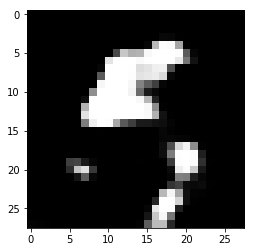

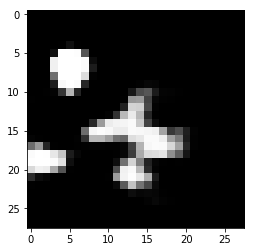

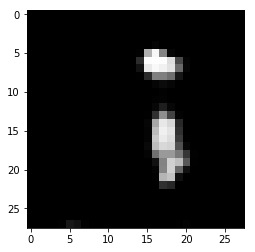

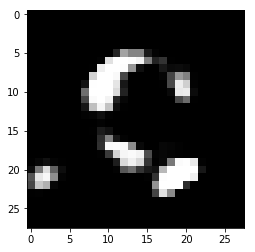

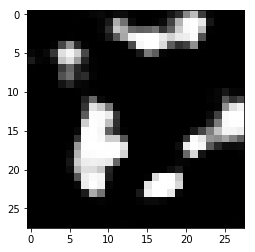

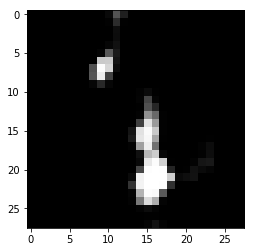

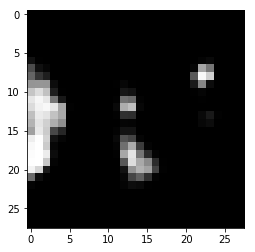

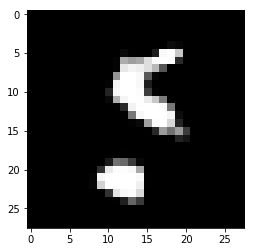

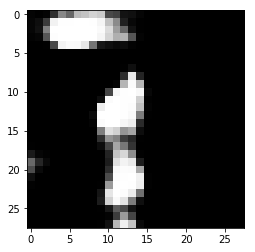

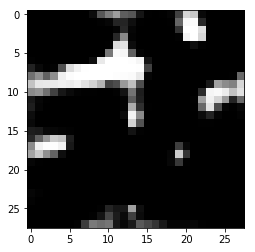

In [86]:
test_pred(g, d)